In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp classify_image

In [3]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *

In [4]:
collection_name = 'food'
table = 'foods'

In [5]:
#export
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [6]:
#export
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

In [7]:
url = 'https://d18mqtxkrsjgmh.cloudfront.net/public/2021-03/Eating%20More%20Ultraprocessed%20%E2%80%98Junk%E2%80%99%20Food%20Linked%20to%20Higher%20CVD%20Risk.jpeg'

In [8]:
import numpy as np
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)

1 get K best matches

2 find farthers K neighbours

3 cluster by similarity and count

In [9]:
# df = df[df['score']>0.25]

In [10]:
import pandas as pd

In [11]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [12]:
#1 

topk = 70
n_farthest = 70
clustering_similarity = 0.7
url = 'http://glovo.away.guru/photos_resized/DLCMMNY_0006497_1735209399.png'
image_clip,top_text = search_image(url,head=topk)
r = pd.DataFrame()


#2
clip = series2tensor(top_text['clip'])


top_text['score1'] =cos(clip, clip[0].reshape(1,768))


top_text['score2'] =cos(clip, clip[top_text.sort_values("score1",ascending=False).iloc[-1].name].reshape(1,768))
for i in range(3,n_farthest+1):
    top_text[f'score{i}'] =cos(clip, clip[top_text[top_text.columns[top_text.columns.str.contains('score')]]         .sum(1).sort_values().index[0]].reshape(1,768))
farthest = top_text[(top_text[top_text.columns[top_text.columns.str.contains('score')]]==1).any(1)][['description','clip']]
# farthest = top_text
while len(farthest)>0:
    clip = series2tensor(farthest['clip'])
    farthest['score'] = cos(clip, clip[0].reshape(1,768))
    farthest.loc[farthest['score']>clustering_similarity,'res'] = farthest['description'].iloc[0]
    r = r.append(farthest[farthest['score']>clustering_similarity].drop(columns = ['score']))
    farthest = farthest[farthest['score']<clustering_similarity]
rr = r.groupby('res')['description'].count().sort_values(ascending=False);rr

/tmp/ipykernel_1850673/2423156918.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


res
Egg, white, cooked, NS as to fat                                  3
Pepper, Serrano, raw                                              2
Chicken dinner, NFS, frozen meal                                  1
Eggs a la Malaguena, Puerto Rican style                           1
Fajita with chicken and vegetables                                1
Huevos rancheros                                                  1
Pork steak or cutlet, NS as to cooking method, lean only eaten    1
Quesadilla with chicken, from fast food                           1
Turkey or chicken burger, on wheat bun                            1
Name: description, dtype: int64

In [13]:
url = 'https://cdn.vox-cdn.com/thumbor/jtEVKt2pZqDDw83Y9ui49oMgW6k=/0x408:1440x1692/1200x900/filters:focal(694x879:924x1109)/cdn.vox-cdn.com/uploads/chorus_image/image/70799805/158441813_3544315102346387_4750868163804111945_n.0.jpg'
image_clip,top_text = search_image(url,head=50)
selected = top_text.copy()

In [14]:
# selected = r.drop_duplicates('res')


In [15]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
prevscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))


In [16]:

for i in range(clip.shape[0],0,-1):
    T = torch.cat([clip[0:i], clip[i+1:]])
    score = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768)) #dropped the tested element
    if score > prevscore: 
        selected = selected.drop(i).reset_index(drop=True)
        clip = series2tensor(selected['clip'])
        prevscore = score   

print(prevscore)

tensor([0.2795], dtype=torch.float64)


In [17]:

for i in range(clip.shape[0],0,-1):
    T = torch.cat([clip[0:i], clip[i+1:]])
    score = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if score > prevscore: 
        selected = selected.drop(i-1).reset_index(drop=True)
        clip = series2tensor(selected['clip'])
    else:
        T = torch.cat([clip, clip[i-1].reshape(1,768)])
        score = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if score > prevscore: 
            selected = selected.append(selected.loc[i-1]).reset_index(drop=True)
        
        prevscore = score   

print(prevscore)

tensor([0.2752], dtype=torch.float64)


In [18]:
clip.shape

torch.Size([15, 768])

In [19]:
clip[i].reshape(1,768).shape

torch.Size([1, 768])

In [20]:
torch.cat([clip, clip[i]])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
clip[i]

IndexError: index 50 is out of bounds for dimension 0 with size 50

In [21]:
selected

,id,description,category,energy,protein,carb,fat,clip,score
0,1102236,"Pasta with tomato-based sauce and seafood, rea...","Pasta mixed dishes, excludes macaroni and cheese",124.0,5.45,19.00,2.98,"[0.01477099, 0.017689189, 0.0034197834, -0.035...",0.242140
1,1102259,"Pasta with cream sauce and seafood, home recipe","Pasta mixed dishes, excludes macaroni and cheese",151.0,5.95,16.85,6.53,"[0.009155464, 0.020748027, -0.0014221615, -0.0...",0.240397
2,1102235,"Pasta with tomato-based sauce and seafood, hom...","Pasta mixed dishes, excludes macaroni and cheese",110.0,5.58,19.42,1.19,"[0.021864535, 0.0034944995, 0.010383741, -0.04...",0.238518
3,1102307,"Pasta, whole grain, with cream sauce and seafo...","Pasta mixed dishes, excludes macaroni and cheese",146.0,6.05,16.44,6.94,"[0.023398208, 0.02459252, -0.010224212, -0.016...",0.235051
4,1102237,"Pasta with tomato-based sauce, seafood, and ad...","Pasta mixed dishes, excludes macaroni and cheese",161.0,5.17,17.76,7.87,"[0.03449896, 0.010599494, 0.001431395, -0.0151...",0.231344
5,1099144,"Scallops, baked or broiled, no added fat",Shellfish,85.0,14.81,4.00,0.60,"[0.03239741, 0.024773775, -0.023522321, -0.036...",0.228751
6,1102261,"Pasta with cream sauce, seafood, and added veg...","Pasta mixed dishes, excludes macaroni and cheese",190.0,5.46,15.85,11.61,"[0.02383237, 0.02326933, -0.016260445, -0.0027...",0.226931
7,1102228,"Pasta with tomato-based sauce and poultry, res...","Pasta mixed dishes, excludes macaroni and cheese",167.0,5.60,17.74,8.42,"[0.034097534, 0.039221514, -0.000910852, -0.00...",0.224997
8,1098149,Alfredo sauce with seafood,"Dips, gravies, other sauces",144.0,6.11,1.76,12.56,"[0.0024527004, 0.02530213, 0.002376126, -0.004...",0.220673
9,1099412,Fish and noodles with mushroom sauce,Seafood mixed dishes,131.0,6.30,14.79,5.10,"[0.00039513462, -0.012440351, -0.01520614, 0.0...",0.218520


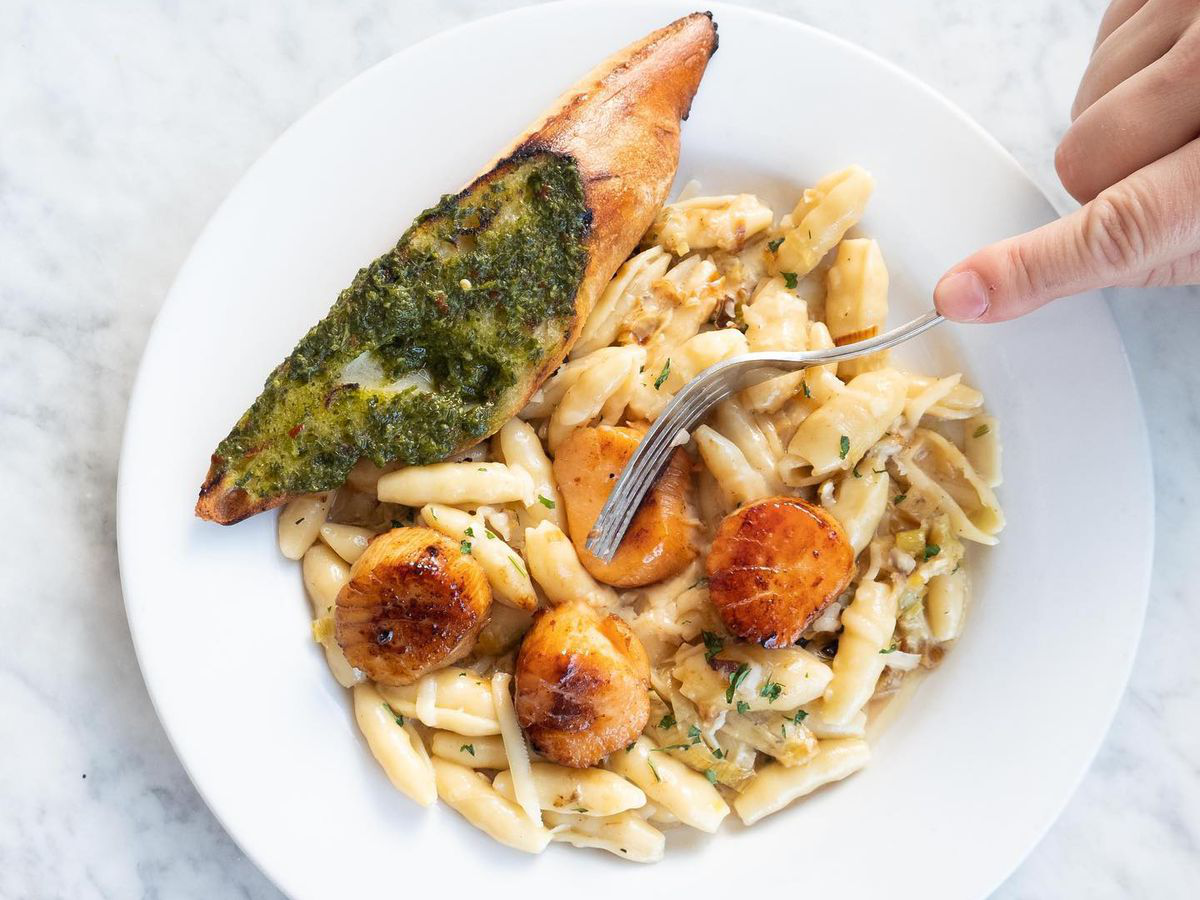

In [22]:
read_image_from_url(url)

In [122]:
clip[:-1].shape

torch.Size([10, 768])

In [130]:
cos(image_clip.reshape(1,768), clip[:-4].mean(0).reshape(1,768))

tensor([0.2865], dtype=torch.float64)

In [107]:
diff = image_clip - clip[0]

In [102]:
clip[0]+clip[1]

tensor([ 2.7741e-02, -3.8993e-02,  5.7437e-03,  1.2802e-02,  6.0040e-02,
         4.4046e-02,  5.8735e-02,  7.9119e-03, -3.6657e-02, -5.1255e-02,
         6.8734e-02,  1.7363e-02,  2.8020e-02,  7.3516e-02, -6.6234e-02,
        -7.7014e-02,  1.7483e-02,  7.4802e-02,  2.3012e-02, -2.6448e-02,
        -2.4560e-02,  4.6162e-02,  1.3197e-01,  7.6253e-03, -1.6475e-02,
        -4.9309e-02,  2.9470e-03, -1.8589e-02,  3.3957e-02, -1.1876e-02,
        -5.2195e-03, -3.4976e-02, -2.5620e-02,  1.0164e-02, -6.7047e-02,
         1.6811e-02, -1.3937e-03,  1.5861e-02, -2.1626e-02,  9.3670e-02,
        -5.4282e-02,  1.7670e-02,  1.3813e-03, -1.2268e-02, -1.0336e-01,
        -3.1287e-02, -2.0781e-02,  2.6864e-02,  1.1741e-02, -4.8889e-02,
        -2.2743e-04, -4.2085e-02, -3.4975e-02,  8.1391e-02,  3.4851e-02,
        -1.1695e-01,  8.4229e-02,  8.1316e-04,  3.5830e-03, -1.4711e-02,
         4.0390e-02,  2.1770e-02,  6.6131e-02, -8.4020e-02,  1.8955e-02,
        -1.1433e-02, -5.3266e-02,  6.6208e-02,  4.6

In [101]:
image_clip - clip[0]

TypeError: rsub() received an invalid combination of arguments - got (Tensor, list), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
diff = prompt_clip - clip
clip = clip + diff*prompt_factor

In [ ]:
image_clip

In [100]:
clip

tensor([[ 0.0015, -0.0257,  0.0022,  ...,  0.0047, -0.0148, -0.0192],
        [ 0.0263, -0.0133,  0.0035,  ..., -0.0376, -0.0385, -0.0366],
        [-0.0082,  0.0246, -0.0019,  ..., -0.0194,  0.0126,  0.0311],
        ...,
        [ 0.0576,  0.0123, -0.0040,  ...,  0.0104, -0.0243, -0.0124],
        [ 0.0220,  0.0289,  0.0392,  ...,  0.0094, -0.0548,  0.0160],
        [ 0.0208,  0.0322,  0.0037,  ..., -0.0520, -0.0430, -0.0320]],
       dtype=torch.float64)

In [14]:
from transformers import AutoTokenizer, AutoModelWithLMHead, SummarizationPipeline


In [16]:

pipeline = SummarizationPipeline(
    model=AutoModelWithLMHead.from_pretrained("SEBIS/code_trans_t5_small_program_synthese_transfer_learning_finetune"),
    tokenizer=AutoTokenizer.from_pretrained("SEBIS/code_trans_t5_small_program_synthese_transfer_learning_finetune", skip_special_tokens=True),
    # device=0
)


'Fish, NS as to type, baked or broiled, made with margarineFish fillet, fried as ingredient in sandwichesFish in lemon-butter sauce with starch item, vegetable, frozen mealFlounder, coated, fried, made with cooking sprayPerch, coated, fried, made with margarinePompano, coated, baked or broiled, no added fatPorgy, baked or broiled, no added fatWhiting, baked or broiled, made with cooking spray'

In [26]:

tokenized_code = ' '.join(aa)
pipeline([tokenized_code])

[{'summary_text': '[ + [ + [ * [ - [ floor [ sqrt [ + [ * [ - ['}]

In [27]:
tokenized_code

'Fish, NS as to type, baked or broiled, made with margarine Fish fillet, fried as ingredient in sandwiches Fish in lemon-butter sauce with starch item, vegetable, frozen meal Flounder, coated, fried, made with cooking spray Perch, coated, fried, made with margarine Pompano, coated, baked or broiled, no added fat Porgy, baked or broiled, no added fat Whiting, baked or broiled, made with cooking spray'

res
Fish, NS as to type, baked or broiled, made with margarine             6
Fish fillet, fried as ingredient in sandwiches                         1
Fish in lemon-butter sauce with starch item, vegetable, frozen meal    1
Flounder, coated, fried, made with cooking spray                       1
Perch, coated, fried, made with margarine                              1
Pompano, coated, baked or broiled, no added fat                        1
Porgy, baked or broiled, no added fat                                  1
Whiting, baked or broiled, made with cooking spray                     1
Name: description, dtype: int64

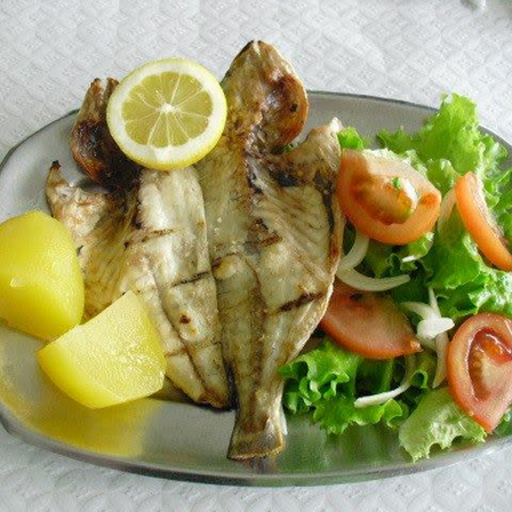

In [107]:
!nbdev_build_lib

Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_classfy_image.ipynb.
Converted 0_template copy.ipynb.
Converted 0_template.ipynb.
Converted Untitled-1.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
Converted usda_parsing.ipynb.
